In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

sns.set(style='whitegrid')

In [21]:
# 1️ Load Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_ids = test_df['PassengerId']
train_df
test_df


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
# 2️ Combine data for consistent preprocessing
combined_df = pd.concat([train_df.drop('Survived', axis=1), test_df], ignore_index=True)

In [6]:
# 3️ Feature engineering
combined_df['FamilySize'] = combined_df['SibSp'] + combined_df['Parch'] + 1
combined_df['IsAlone'] = (combined_df['FamilySize'] == 1).astype(int)
combined_df['Title'] = combined_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

title_map = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Dr': 'Other', 'Rev': 'Other', 'Col': 'Other', 'Major': 'Other',
    'Mlle': 'Miss', 'Countess': 'Mrs', 'Ms': 'Miss', 'Lady': 'Mrs',
    'Don': 'Mr', 'Sir': 'Mr', 'Jonkheer': 'Other', 'Dona': 'Mrs', 'Capt': 'Other'
}
combined_df['Title'] = combined_df['Title'].map(title_map)

In [7]:
# 4️ Handle missing values
combined_df['Age'] = combined_df['Age'].fillna(combined_df['Age'].median())
combined_df['Fare'] = combined_df['Fare'].fillna(combined_df['Fare'].median())
combined_df['Embarked'] = combined_df['Embarked'].fillna(combined_df['Embarked'].mode()[0])


In [8]:
# 5️ Create categorical bins
combined_df['AgeGroup'] = pd.cut(combined_df['Age'], bins=[0,16,32,48,64,80], labels=[0,1,2,3,4])
combined_df['FareCategory'] = pd.cut(combined_df['Fare'], 4, labels=[0,1,2,3])
combined_df['Deck'] = combined_df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'M')


In [9]:

# 6️ Drop unused columns
combined_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'Fare'], axis=1, inplace=True)

In [ ]:

# 7️ One-hot encoding
combined_df = pd.get_dummies(
    combined_df,
    columns=['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareCategory', 'Deck'],
    drop_first=True
)

In [11]:
# 8️ Split back into train and test
X_train_full = combined_df.iloc[:len(train_df), :]
X_test_submission = combined_df.iloc[len(train_df):, :]
y_train_full = train_df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [12]:
# 9️ Random Forest with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
model.fit(X_train, y_train)
best_model = model.best_estimator_

In [14]:
# 1️0️ Validation
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

print(f"Best Hyperparameters: {model.best_params_}\n")
print(f"Validation Accuracy Score: {accuracy_score(y_val, y_pred):.4f}\n")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Validation Accuracy Score: 0.8101

Confusion Matrix:
 [[92 13]
 [21 53]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



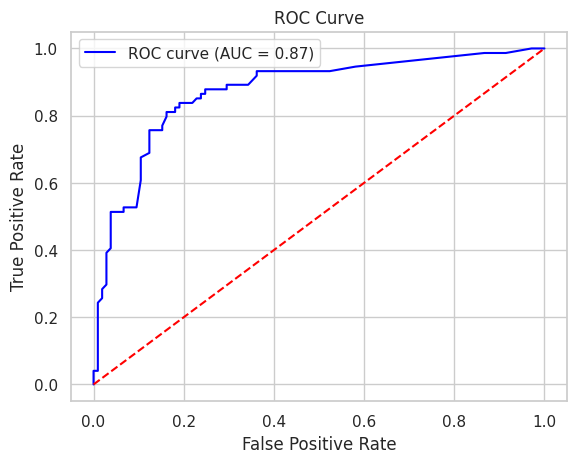

In [15]:
# 1️1️ ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:

# 1️⃣2️⃣ Predict on test set & create submission
final_prediction = best_model.predict(X_test_submission)
submission = pd.DataFrame({'PassengerId': submission_ids, 'Survived': final_prediction})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully!")



Submission file 'submission.csv' created successfully!
